# Settings 

In [1]:
import cptdl as cdl
import cptio as cio
import cptcore as cc 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import xarray as xr 
import datetime as dt 
import numpy as np 
from dateutil.relativedelta import relativedelta 
from pathlib import Path 

workdir = "sea-may2021_ini_apr"

models = ['CanSIPSv2.SST', 'CCSM4.SST','GEOSS2S.SST']
observations = 'UCSB.PRCP'
predictor_extent = { 'north': 30, 'south': -1, 'east': -45, 'west': -120}
predictand_extent = { 'north': 30, 'south': -1, 'east': -45, 'west': -120}

initializations = [ dt.datetime(2021, 4, 1) ]
targets = [ 'May-Jul' ]

first_year = 1982 
final_year = 2015

cca_modes = (1, 5)
x_eof_modes = (1, 5)
y_eof_modes = (1, 5)

crossvalidation_window = 5
synchronous_predictors=True
transform_predictand=None
tailoring=None

force_download = True
verbosity = 1

# CPT Analysis

In [2]:
workdir = Path(workdir).absolute()
inputs = workdir / 'inputs'
cca_outputs = workdir / 'cca_outputs'
pcr_outputs = workdir / 'pcr_outputs'
nomos_outputs = workdir / 'nomos_outputs'
scripts = workdir / 'scripts'

if not workdir.is_dir():
    workdir.mkdir(exist_ok=True, parents=True)
if not inputs.is_dir():
    inputs.mkdir(exist_ok=True, parents=True)
if not cca_outputs.is_dir():
    cca_outputs.mkdir(exist_ok=True, parents=True)
if not pcr_outputs.is_dir():
    pcr_outputs.mkdir(exist_ok=True, parents=True)
if not nomos_outputs.is_dir():
    nomos_outputs.mkdir(exist_ok=True, parents=True)
if not scripts.is_dir():
    scripts.mkdir(exist_ok=True, parents=True)
    
assert len(initializations) == len(targets), "You must give one initialization per target"
leads = [ cio.leads_from_target(initializations[i], targets[i]) for i in range(len(initializations))]

for i, fdate in enumerate(initializations):
    for model in models: 
        kwargs = { 
            'lead_low': leads[i][0], 
            'lead_high': leads[i][1], 
            'fdate': fdate, 
            'target': targets[i], 
            'predictor_extent': predictor_extent, 
            'predictand_extent': predictand_extent, 
            'first_year': first_year, 
            'final_year': final_year,
            'filetype': 'cptv10.tsv',
        }
        
        (cca_outputs/model).mkdir(exist_ok=True, parents=True)
        (pcr_outputs/model).mkdir(exist_ok=True, parents=True)
        (nomos_outputs/model).mkdir(exist_ok=True, parents=True)
        
        x_template = cdl.hindcasts[model]
        x_filename = inputs / "{}_{}_ini{}.tsv".format(model.replace('.', '_'), targets[i], cio.threeletters[fdate.month])
        if force_download or not x_filename.is_file():
            if verbosity: 
                print('DOWNLOADING PREDICTORS FOR {} - {}'.format(model, targets[i]))
            X = cdl.download(x_template, x_filename, verbose=verbosity, **kwargs)
        else: 
            if verbosity: 
                print('ALREADY DOWNLOADED PREDICTORS FOR {} - {}'.format(model, targets[i]))
            X = cio.open_cptdataset(x_filename)
        X = getattr(X, [var for var in X.data_vars][0])
        if verbosity:
            print('LOADED PREDICTORS ')
            if verbosity > 1:
                print(X)
                print()
        
        y_template = cdl.observations[observations]
        y_filename = inputs / "obs_{}_{}.tsv".format(observations.replace('.', '_'), targets[i])
        if force_download or not y_filename.is_file():
            if verbosity:
                print('DOWNLOADING PREDICTANDS FOR {} - {}'.format(observations, targets[i]))
            Y = cdl.download(y_template, y_filename, verbose=verbosity, **kwargs)
        else:
            if verbosity: 
                print('ALREADY DOWNLOADED PREDICTANDS FOR {} - {}'.format(observations, targets[i]))
            Y = cio.open_cptdataset(y_filename)
        Y = getattr(Y, [var for var in Y.data_vars][0])
        if verbosity:
            print('LOADED Y ')
            if verbosity > 1:
                print(Y)
                print()
        
        f_template = cdl.forecasts[model]
        f_filename = inputs / "{}_{}_ini{}{}.tsv".format(model.replace('.', 'fcst_'), targets[i], cio.threeletters[fdate.month], fdate.year)
        if force_download or not f_filename.is_file():
            if verbosity: 
                print('DOWNLOADING FORECAST PREDICTORS FOR {} - {}'.format(model, targets[i]))
            F = cdl.download(f_template, f_filename, verbose=verbosity, **kwargs)
        else: 
            if verbosity: 
                print('ALREADY DOWNLOADED FORECAST PREDICTORS FOR {} - {}'.format(model, targets[i]))
            F = cio.open_cptdataset(f_filename)
        F = getattr(F, [var for var in F.data_vars][0])
        if verbosity:
            print('LOADED FORECAST PREDICTORS ')
            if verbosity > 1:
                print(F)
                print()
                
                
        if verbosity:
            print('STARTING CCA RUN')
        cca_hcst, cca_fcst, cca_skill, cca_px, cca_py = cc.canonical_correlation_analysis(X, Y, F=F, crossvalidation_window=crossvalidation_window, transform_predictand=transform_predictand, tailoring=tailoring, synchronous_predictors=synchronous_predictors, cpt_kwargs={'log': scripts/'{}_cca_log.txt'.format(model), 'outputdir': cca_outputs / model } )
        cca_hcst.to_netcdf(cca_outputs / model / "crossvalidated_hindcasts.nc")
        cca_fcst.to_netcdf(cca_outputs / model / "out-of-sample_forecasts.nc")
        cca_skill.to_netcdf(cca_outputs / model /'deterministic_skill.nc')
        cca_px.to_netcdf(cca_outputs / model / 'predictor_patterns.nc')
        cca_py.to_netcdf(cca_outputs / model / 'predictand_patterns.nc')
        
        if verbosity:
            print('STARTING PCR RUN')
        pcr_hcst, pcr_fcst, pcr_skill, pcr_px = cc.principal_components_regression(X, Y, F=F, crossvalidation_window=crossvalidation_window, transform_predictand=transform_predictand, tailoring=tailoring, synchronous_predictors=synchronous_predictors, cpt_kwargs={'log': scripts/'{}_pcr_log.txt'.format(model), 'outputdir': pcr_outputs / model }  )
        pcr_hcst.to_netcdf(pcr_outputs / model / "crossvalidated_hindcasts.nc")
        pcr_fcst.to_netcdf(pcr_outputs / model / "out-of-sample_forecasts.nc")
        pcr_skill.to_netcdf(pcr_outputs / model /'deterministic_skill.nc')
        pcr_px.to_netcdf(pcr_outputs / model / 'predictor_patterns.nc')
        
        if verbosity:
            print('STARTING NOMOS (Skill-Only) RUN')
        deterministic_skill = cc.deterministic_skill(X, Y, synchronous_predictors=synchronous_predictors, cpt_kwargs={'log': scripts/'nomos_log.txt', 'outputdir': nomos_outputs / model } )
        deterministic_skill.to_netcdf(nomos_outputs / model /'deterministic_skill.nc')
        
        if verbosity:
            print('STARTING IN-SAMPLE RETROACTIVE FORECAST RUNS')
            
        # now some shenanigans for the probabilistic skill - making in-sample forecasts
        X2 = X.copy()
        for t in ['T', 'S', 'Ti', 'Tf']:
            if t in X2.coords.keys():
                X2 = X2.assign_coords({t:  ('T', [cio.convert_np64_datetime(j) + relativedelta(years=100) for j in X.coords[t].values ]) } ) 
        
        pr_cca_hcst, pr_cca_fcst, pr_cca_skill, pr_cca_px, pr_cca_py = cc.canonical_correlation_analysis(X, Y, F=X2, crossvalidation_window=crossvalidation_window, transform_predictand=transform_predictand, tailoring=tailoring, synchronous_predictors=synchronous_predictors )
        pr_pcr_hcst, pr_pcr_fcst, pr_pcr_skill, pr_pcr_px = cc.principal_components_regression(X, Y, F=X2, crossvalidation_window=crossvalidation_window, transform_predictand=transform_predictand, tailoring=tailoring, synchronous_predictors=synchronous_predictors )

        cca_probabilistic_hindcasts = pr_cca_fcst.probabilistic
        pcr_probabilistic_hindcasts = pr_pcr_fcst.probabilistic
        for t in ['T', 'S', 'Ti', 'Tf']:
            if t in cca_probabilistic_hindcasts.coords.keys():
                cca_probabilistic_hindcasts = cca_probabilistic_hindcasts.assign_coords({t: ('T', [cio.convert_np64_datetime(j) + relativedelta(years=-100) for j in cca_probabilistic_hindcasts.coords[t].values ])})
                pcr_probabilistic_hindcasts = pcr_probabilistic_hindcasts.assign_coords({t: ('T', [cio.convert_np64_datetime(j) + relativedelta(years=-100) for j in pcr_probabilistic_hindcasts.coords[t].values ])})
        
        if verbosity:
            print('STARTING IN-SAMPLE PFV RUNS')
        cca_pfv = cc.probabilistic_forecast_verification(cca_probabilistic_hindcasts, Y)
        pcr_pfv = cc.probabilistic_forecast_verification(cca_probabilistic_hindcasts, Y)
                 
        if verbosity:
            print('SAVING FILES')
        cca_pr_hcst_file = cio.to_cptv10(pr_cca_fcst.probabilistic, opfile=cca_outputs / model / "tercile_probabilistic_hindcasts" ) 
        cca_pev_hcst_file = cio.to_cptv10(pr_cca_fcst.prediction_error_variance, opfile=cca_outputs /model /  "prediction_error_variance_hindcasts" ) 
        pcr_pr_hcst_file = cio.to_cptv10(pr_pcr_fcst.probabilistic, opfile=pcr_outputs / model / "tercile_probabilistic_hindcasts" ) 
        pcr_pr_hcst_file = cio.to_cptv10(pr_pcr_fcst.prediction_error_variance, opfile=pcr_outputs / model / "prediction_error_variance_hindcasts" )
        
        cca_pfv.to_netcdf(cca_outputs / model / 'probabilistic_forecast_verification.nc')
        pcr_pfv.to_netcdf(pcr_outputs / model /'probabilistic_forecast_verification.nc')
        
        if verbosity:
            print('DONE - model: {} observations: {} target: {} initialization: {}'.format(model, observations, targets[i], fdate))
            print()
                      

DOWNLOADING PREDICTORS FOR CanSIPSv2.SST - May-Jul
LOADED PREDICTORS 
DOWNLOADING PREDICTANDS FOR UCSB.PRCP - May-Jul
URL: https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/92/mul/T/(1%20Jan%201982)/(31%20Dec%202015)/RANGE/T/%28May-Jul%201982-2015%29/seasonalAverage/Y/%28-1%29/%2830%29/RANGEEDGES/X/%28-120%29/%28-45%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv

DOWNLOADING: [*************************] (17982 KB) 0:00:22.273585
LOADED Y 
DOWNLOADING FORECAST PREDICTORS FOR CanSIPSv2.SST - May-Jul
LOADED FORECAST PREDICTORS 
STARTING CCA RUN
STARTING PCR RUN
STARTING NOMOS (Skill-Only) RUN
STARTING IN-SAMPLE RETROACTIVE FORECAST RUNS
STARTING IN-SAMPLE PFV RUNS
SAVING FILES
DONE - model: CanSIPSv2.SST observations: UCSB.PRCP target: May-Jul initialization: 2021-04-01 00:00:00

DOWNLOADING PREDICTORS FOR CCSM4.SST - May-Jul
LOADED PREDICTORS 
DOWNLOADING PREDICTANDS FOR UCSB.PRCP - May-Jul
URL: https://iridl.ldeo.columbia.edu

# Deterministic Skill Evaluation

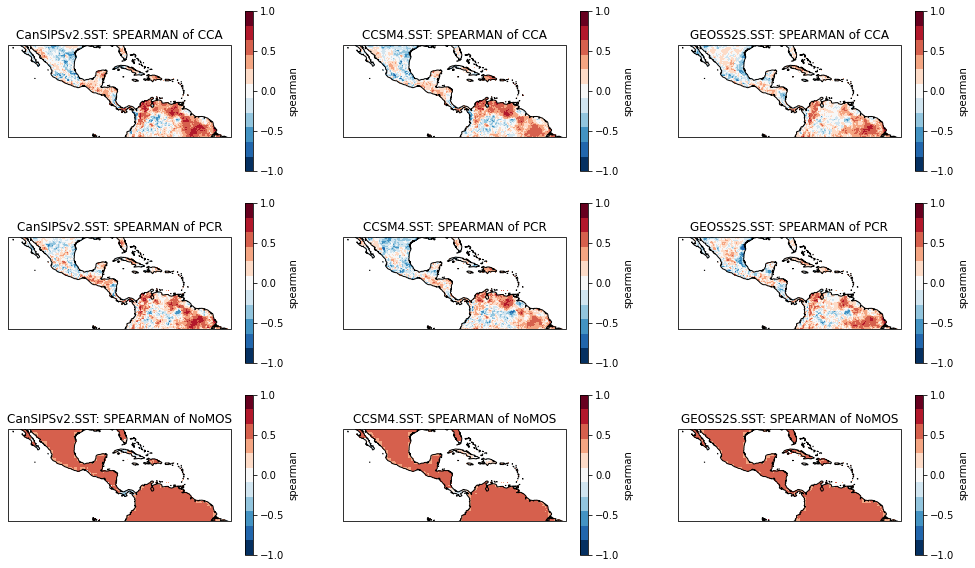

In [28]:
skill_to_plot = "spearman"

import xarray as xr 
fig, ax = plt.subplots(nrows=3, ncols=len(models), figsize=(len(models)*5 +2, 10), subplot_kw={'projection': ccrs.PlateCarree()} )
cca_skills = [ xr.open_dataset(cca_outputs / model / 'deterministic_skill.nc') for model in models ] 
pcr_skills = [ xr.open_dataset(pcr_outputs / model / 'deterministic_skill.nc') for model in models ] 
nomos_skills = [ xr.open_dataset(nomos_outputs / model / 'deterministic_skill.nc') for model in models ] 

for i, model in enumerate(models):
    getattr(cca_skills[i].where(cca_skills[i] != -999, other=np.nan), skill_to_plot).plot(ax=ax[0][i], vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu_r', 11))
    getattr(pcr_skills[i].where(pcr_skills[i] != -999, other=np.nan), skill_to_plot).plot(ax=ax[1][i], vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu_r', 11))
    getattr(nomos_skills[i].where(nomos_skills[i] != -999, other=np.nan), skill_to_plot).plot(ax=ax[2][i], vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu_r', 11))
    ax[0][i].set_title('{}: {} of CCA'.format(model, skill_to_plot.upper()))
    ax[1][i].set_title('{}: {} of PCR'.format(model, skill_to_plot.upper()))
    ax[2][i].set_title('{}: {} of NoMOS'.format(model, skill_to_plot.upper()))
    ax[0][i].coastlines()
    ax[1][i].coastlines()
    ax[2][i].coastlines()
    

# NextGen Ensemble Forecasts

In [32]:
ensemble_members = ['CanSIPSv2.SST', 'CCSM4.SST','GEOSS2S.SST']

hindcasts, forecasts = [], []
for i, member in enumerate(ensemble_members):
    hcsts = xr.open_dataset(cca_outputs / member / 'crossvalidated_hindcasts.nc')
    fcsts = xr.open_dataset(cca_outputs / member / 'out-of-sample_forecasts.nc')
    hindcasts.append(hcsts)
    forecasts.append(fcsts)

hindcasts = xr.concat(hindcasts, 'M').mean('M')
forecasts = xr.concat(forecasts, 'M').mean('M')

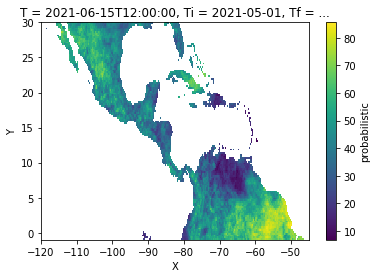

In [40]:
forecasts.probabilistic.isel(T=-1, C=2).plot()